# Check and analysis gojek app sentimen

In [545]:
#dataFrame
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
#NLTK
import nltk
from nltk.corpus import stopwords

#keras
from keras.models import Sequential


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

#helper
from collections import Counter
import emoji
import re
import time
import os
import logging
import pickle
import itertools


In [546]:
#read dataset
df = pd.read_csv("datagojekcopy.csv")
print(df.shape)

(20000, 4)


In [547]:
df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,sip... terima kasih 🙏
1,mimi cedar,5,2023-03-30 14:35:59,Bagaimana cara transfer sesama Gopay. Gopay sa...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,"Aman,dan cepat. Sesuai dengan ekspektasi.👍🏼👍🏼"
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,. aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,Cepet sampainya


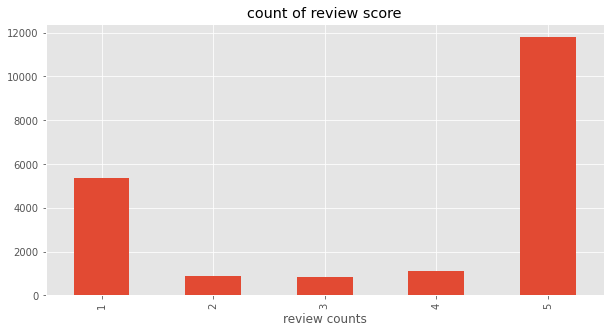

In [548]:
ax =df['score'].value_counts().sort_index().plot(
        kind = 'bar',
        title = 'count of review score',
        figsize = (10,5))
ax.set_xlabel("review counts")
plt.show()

# Preprocessing text
- menghilangkan emoji
- menghilangkan symbol
- stemmer
- word_stops

In [549]:
#Prepare preprocessing text
COBA = '\.'
TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = set(stopwords.words("indonesian"))
retain_words = {'baik','sekali'} #menghapus stopword dari kata baik sekali
stop_words = stop_words - retain_words
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [550]:
# Remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol & piktograf
                               u"\U0001F680-\U0001F6FF"  # transport & simbol peta
                               u"\U0001F1E0-\U0001F1FF"  # bendera (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub('',text)

In [551]:
# remove all emoji
def remove_all(text):
    sentence = remove_emoji(text)
    return sentence
    

In [552]:
df.content = df.content.apply(lambda x:remove_all(x))

In [553]:
df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,sip... terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,Bagaimana cara transfer sesama Gopay. Gopay sa...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,"Aman,dan cepat. Sesuai dengan ekspektasi."
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,. aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,Cepet sampainya


In [554]:
df.shape

(20000, 4)

In [555]:
#drop null content
for x in df.index:
    if df.loc[x,'content'] == "":
        df.drop(x, inplace = True)
df.shape

(19722, 4)

In [556]:
#menghilangkan symbol
def remove_symbol(text):
    text = re.sub(COBA,'',str(text).strip())
    return text

In [557]:
#menghilangkan symbol
def remove_symbol_clean(text):
    text = re.sub(TEXT_CLEANING_RE,' ',str(text).lower().strip())
    return text

In [558]:
#stopwords
def stopWordsData(text, stem = False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

# Cleaning singkatan kata

In [559]:
#read_dataset singkatan (data didapat dari scrapping data)
df_singkatan_scrap = pd.read_csv("singkatan_1_kata.csv")
df_singkatan_scrap.head()

,Singkatan,Kata
0,7an,tujuan
1,@,di
2,ababil,abg labil
3,abis,habis
4,acc,accord


In [560]:
#pindahkan ke dictionary
singkatan_dict_scrap = dict(zip(df_singkatan_scrap['Singkatan'], df_singkatan_scrap['Kata']))
df_singkatan_scrap.shape

(1481, 2)

In [561]:
#Membuat function mengubah singkatan dari bahasa indonesia
singkatan = {
    #a
    "apaa": "apa",
    "apaaa": "apa",
    "apaaaa": "apa",
    #"aplikasinya": "aplikasi",
    #b
    "bagu": "bagus",
    "bsa": "bisa",
    "byk": "banyak",
    #c
    #d
    "donlod"
    "dowload": "download",
    "da": "ada",
    "dll": "dan lain-lain",
    "d": "di",
    #e
    "elu": "kamu",
    #f
    #g
    "gbisa": "gak bisa",
    "gagu": "gak guna",
    "g": "gak",
    "gk": "gak",
    "gohek": "gojek",
    "goek": "gojek",
    #h
    #i
    "instal": "install",
    #j
    #k
    "knp": "kenapa",
    #l
    "loding":"loading",
    "lg": "lagi",
    "li": "beli",
    "lu": "kamu",
    #m
    "mantaap" : "mantap",
    "mantapp": "mantap",
    "mantaf": "mantap",
    #n
    "n": "dan",
    "nya" :"",
    #o
    #p
    "parahh": "parah",
    "parahhh": "parah",
    "parahhhh": "parah",
    "pedning": "pending",
    #q
    #r
    #s
    "sp": "siapa",
    "sdh": "sudah",
    "sngt": "sangat",
    #t
    "tq": "thank you",
    "tp": "tapi",
    "trs": "terus",
    "trims": "terima kasih",
    #u
    "u": "kamu",
    "udh": "udah",
    #v
    #w
    #x
    #y
    "yg": "yang",
    "sy": "saya",
    "y": "iya"
    #z
    
}

df_singkatan = pd.DataFrame(list(singkatan.items()),columns = ['singkatan','kata'])
singkatan_dict = dict(zip(df_singkatan['singkatan'], df_singkatan['kata']))

def changeAbbreviation_DF(text):
    words = text.split()
    new_words = [singkatan_dict[word] if word in singkatan_dict else word for word in words]
    return " ".join(new_words)

def changeAbbreviation_DF_scrap(text):
    words = text.split()
    new_words =[singkatan_dict_scrap[word] if word in singkatan_dict_scrap else word for word in words]
    return " ".join(new_words)

def changeAbbreviation(text):
    words = text.split()
    
    for i in range(len(words)):
        if words[i] in df_singkatan['singkatan']:
            words[i] = df_singkatan['kata',[words[i]]]
    return " ".join(words)

In [562]:
#remove symbol tandak titik .
df.content = df.content.apply(lambda x: remove_symbol(x))

In [563]:
#normalisasi mengubah singkatan
df.content = df.content.apply(lambda x: changeAbbreviation_DF(x))

In [564]:
text = df.loc[33,'content']
print(text)

pas di gunakan untuk pembayaran gak bisa di gunakan padahal udah gak bawa uang lagi dana ada di gopay menjengkelkan buang waktu malu maluin aja payah


In [565]:
text = df.loc[33,'content']
print(text)

pas di gunakan untuk pembayaran gak bisa di gunakan padahal udah gak bawa uang lagi dana ada di gopay menjengkelkan buang waktu malu maluin aja payah


In [566]:
text = df.loc[45,'content']
print(text)

Tiba" akun hrs upgrade ke gopplus padahal saya pengguna dr tahun 2016 dan smua transaksi berantakan


In [567]:
#normalisasi mengubah singkatan
df.content = df.content.apply(lambda x: changeAbbreviation_DF_scrap(x))

In [568]:
text = df.loc[45,'content']
print(text)

Tiba" akun harus              upgrade ke gopplus padahal saya pengguna dari              tahun 2016 dan semua              transaksi berantakan


In [569]:
#hapus symbol
df.content = df.content.apply(lambda x: remove_symbol_clean(x))

In [570]:
text = df.loc[45,'content']
print(text)

tiba akun harus upgrade ke gopplus padahal saya pengguna dari tahun 2016 dan semua transaksi berantakan


In [571]:
#Function Merger preprocessing_text

# def preprocessing_text(text):
#     content = text
#     content = remove_symbol(content)
#     content = changeAbbreviation_DF(content)
#     content = stopWordsData(content)
    
#     return content
    
    

In [572]:
def preprocessing_text(text):
    content = text
    content = remove_all(content)
    content = remove_symbol(content)
    content = changeAbbreviation_DF(content)
    content = changeAbbreviation_DF_scrap(content)
    content = remove_symbol_clean(content)
    content = stopWordsData(content)
    
    return content

## Buat new_df untuk Membuat similiar untuk proses normalisasi

In [573]:
df.loc[45,'content']

'tiba akun harus upgrade ke gopplus padahal saya pengguna dari tahun 2016 dan semua transaksi berantakan'

In [574]:
df.content = df.content.apply(lambda x : preprocessing_text(x))

In [575]:
df.loc[45,'content']

'akun upgrade gopplus pengguna 2016 transaksi berantakan'

In [576]:
new_df = df.reset_index(drop = True)
new_df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya


In [577]:
new_df.content = new_df.content.apply(lambda x: preprocessing_text(x))

In [578]:
new_df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya


# INI ADALAH SAMPLE DATASET HASIL SCRAPING UNTUK TESTING

## sentimen menggunakan Inset based lexicon
link https://github.com/fajri91/InSet

In [579]:
new_df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya


In [580]:
#preprocessed_content
def preprocessed_content(text):
    words = text.split()
    return words

In [581]:
new_df['[preprocessed_content]'] = new_df['content'].apply(lambda x: preprocessed_content(x))

In [582]:
new_df.shape

(19722, 5)

In [583]:
#drop kembali karena melakukan process stopwords yang kata-katanya tidak diketahui
y = 0
for i in new_df.index:
    try:
        if new_df.loc[i, 'content'] == "":
            new_df.drop(i, inplace=True)
            y += 1
    except KeyError:
        continue
print(y)
new_df.shape

127


(19595, 5)

In [584]:
#mereset index kembali setelah di drop
new_df = new_df.reset_index(drop = True)

### READ TSV BASED_LEXICON

In [585]:
#read tsv
#negatif
df_negatif = pd.read_csv('negative.tsv', sep='\t')

In [586]:
df_positif = pd.read_csv('InSet-Master\positive.tsv',sep='\t')

In [587]:
# ad_new = pd.DataFrame({
#     'word': ['perbaiki'],
#     'weight': [-1]
# })

# df_negatif = pd.concat([df_negatif,ad_new], ignore_index=True)
#Merubah lexicon karena kalimat tersebut bersifat positif
#pada dataFrame Negatif
#aplikasi = 0,bagus = 0 ,membantu = 0 
df_negatif.loc[df_negatif['word'] == 'membantu','weight'] = 0
df_negatif.loc[df_negatif['word'] == 'aplikasi','weight'] = 0
df_negatif.loc[df_negatif['word'] == 'bagus','weight'] = 0


#ubah menjadi dictionary
sentiment_lexicon_positif = df_positif.set_index('word')['weight'].to_dict()
sentiment_lexicon_negatif = df_negatif.set_index('word')['weight'].to_dict()

In [588]:
#Function positif
def analyze_sentiment_positif(sentence):
    words = sentence.split()
    sentiment_score = 0
    #hasil = "netral"
    
    for word in words:
        sentiment_score += sentiment_lexicon_positif.get(word, 0)
        
    if sentiment_score > 0:
        return sentiment_score
    elif sentiment_score < 0:
        return sentiment_score
    else:
        return sentiment_score
        
def analyze_sentiment_negatif(sentence):
    words = sentence.split()
    sentiment_score = 0
    #hasil = "netral"
    
    for word in words:
        sentiment_score += sentiment_lexicon_negatif.get(word, 0)
        
    if sentiment_score > 0:
        return sentiment_score
    elif sentiment_score < 0:
        return sentiment_score
    else:
        return sentiment_score

In [589]:
new_df['lexicon_positif'] = 0
new_df['lexicon_negatif'] = 0

In [590]:
new_df.lexicon_positif = new_df.content.apply(lambda x: analyze_sentiment_positif(x))

In [591]:
new_df.lexicon_negatif = new_df.content.apply(lambda x: analyze_sentiment_negatif(x))

In [592]:
final = []
for x in new_df.index:
    hasil = 0
    hasil = new_df.loc[x,'lexicon_positif'] + new_df.loc[x,'lexicon_negatif']
    final.append(hasil)
print("finish")

finish


In [593]:
new_df['final_lexicon'] = final

In [594]:
new_df.head(50)

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[ok, terima, kasih]",8,-1,7
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[transfer, gopay, gopay, transfer, gopay]",0,0,0
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[aman, cepat, sesuai, ekspektasi]",6,-3,3
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[aplikasi, membantu]",4,0,4
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya,"[cepat, sampainya]",3,-3,0
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw,[yihaw],0,0,0
6,Irsya chanel,5,2023-03-30 14:15:20,bagus,[bagus],2,0,2
7,Sunar tiee,2,2023-03-30 13:55:29,kalou perdalam susah dapetnya,"[kalou, perdalam, susah, dapetnya]",0,-3,-3
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali,"[baik, sekali]",3,-2,1
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,top up gopay nomer akun salah kirim orang iya ...,"[top, up, gopay, nomer, akun, salah, kirim, or...",7,-5,2


In [595]:
#change label if lexicon > 0 positive, lexicon < 0 negative, lexicon == 0 neutral
status_lexicon = []

for x in new_df.index:
    status = "neutral"
    if new_df.loc[x,'final_lexicon'] > 0:
        status = "positif"
        status_lexicon.append(status)
    elif new_df.loc[x,'final_lexicon'] < 0:
        status = "negatif"
        status_lexicon.append(status)
    else:
        status_lexicon.append(status)
        
print("finish")

finish


In [596]:
new_df['status_lexicon'] = status_lexicon

In [597]:
#mengubah dari column score menjadi sentimen
#jika score negatif < 3=3 neutral < positif
score_lexicon = []

#menggunakan looping
for i in new_df.index:
    text = "neutral"
    if new_df.loc[i,'score'] < 3:
        text = "negatif"
        score_lexicon.append(text)
    elif new_df.loc[i,'score'] > 3:
        text = "positif"
        score_lexicon.append(text)
    else:
        score_lexicon.append(text)
print("finish")

finish


In [598]:
new_df['score_lexicon'] = score_lexicon

In [599]:
new_df.head(50)

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon,status_lexicon,score_lexicon
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[ok, terima, kasih]",8,-1,7,positif,positif
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[transfer, gopay, gopay, transfer, gopay]",0,0,0,neutral,positif
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[aman, cepat, sesuai, ekspektasi]",6,-3,3,positif,positif
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[aplikasi, membantu]",4,0,4,positif,positif
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya,"[cepat, sampainya]",3,-3,0,neutral,positif
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw,[yihaw],0,0,0,neutral,positif
6,Irsya chanel,5,2023-03-30 14:15:20,bagus,[bagus],2,0,2,positif,positif
7,Sunar tiee,2,2023-03-30 13:55:29,kalou perdalam susah dapetnya,"[kalou, perdalam, susah, dapetnya]",0,-3,-3,negatif,negatif
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali,"[baik, sekali]",3,-2,1,positif,positif
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,top up gopay nomer akun salah kirim orang iya ...,"[top, up, gopay, nomer, akun, salah, kirim, or...",7,-5,2,positif,negatif


## Visualization atau plotting dari based lexicon isset

In [600]:
new_df.shape

(19595, 10)

In [601]:
## Visualization
new_df['status_lexicon'].value_counts()

positif    11618
negatif     4257
neutral     3720
Name: status_lexicon, dtype: int64

In [602]:
## Visualization
new_df['score_lexicon'].value_counts()

positif    12552
negatif     6208
neutral      835
Name: score_lexicon, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

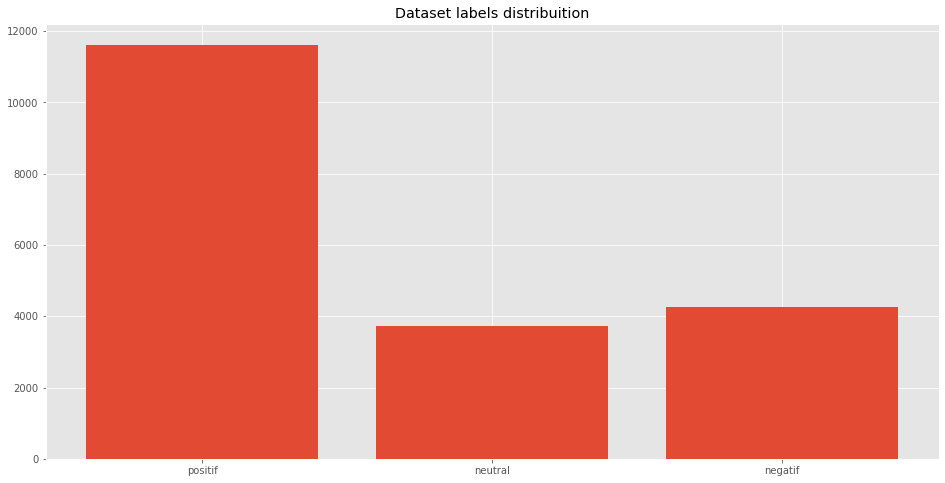

In [603]:
status_cnt = Counter(new_df.status_lexicon)

plt.figure(figsize=(16,8))
plt.bar(status_cnt.keys(), status_cnt.values())
plt.title("Dataset labels distribuition")

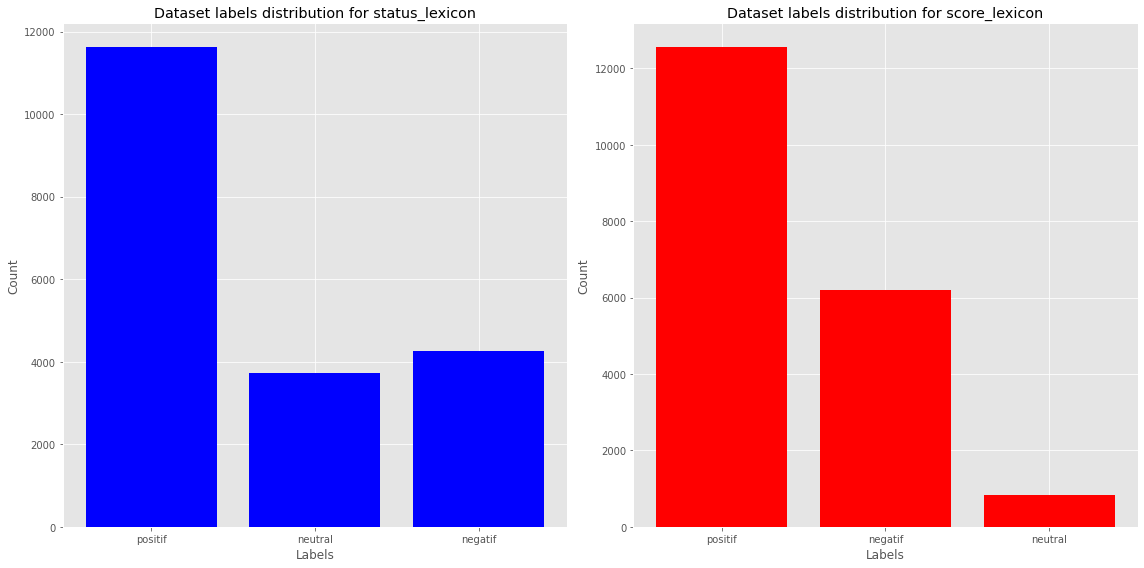

In [604]:
# Menghitung frekuensi dari status_lexicon
status_cnt = Counter(new_df.status_lexicon)

# Menghitung frekuensi dari score_lexicon
score_cnt = Counter(new_df.score_lexicon)

# Membuat figure dengan 2 subplot
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# Visualisasi status_lexicon
ax[0].bar(status_cnt.keys(), status_cnt.values(), color='b')
ax[0].set_title("Dataset labels distribution for status_lexicon")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Labels")

# Visualisasi score_lexicon
ax[1].bar(score_cnt.keys(), score_cnt.values(), color='r')
ax[1].set_title("Dataset labels distribution for score_lexicon")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Labels")

# Menyesuaikan layout
plt.tight_layout()
plt.show()


In [605]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Membuat subplot dengan 1 baris dan 2 kolom
fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

# Menambahkan pie chart pertama untuk status_lexicon
fig.add_trace(go.Pie(labels=list(status_cnt.keys()), values=list(status_cnt.values()), name="status_lexicon",title="status lexicon"),
              1, 1)

# Menambahkan pie chart kedua untuk score_lexicon
fig.add_trace(go.Pie(labels=list(score_cnt.keys()), values=list(score_cnt.values()), name="score_lexicon",title="score lexicon"),
              1, 2)

# Update layout untuk menampilkan judul dan mengubah warna
fig.update_layout(
    title_text="Dataset labels distribution",
    paper_bgcolor="white",
    plot_bgcolor="black",
    font=dict(color="black")
)

# Menampilkan figure
fig.show()


# Visual dengan wordCloud

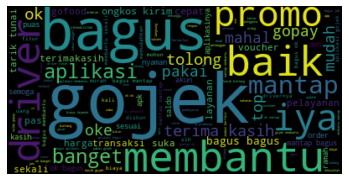

In [606]:
from wordcloud import WordCloud
# Contoh: menggabungkan semua teks dari sentimen positif dalam satu string (asumsi dataframe Anda bernama df dan kolom teksnya bernama 'text')
positive_text = ' '.join(new_df[new_df['status_lexicon'] == 'positif']['content'].tolist())


wc = WordCloud().generate(positive_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

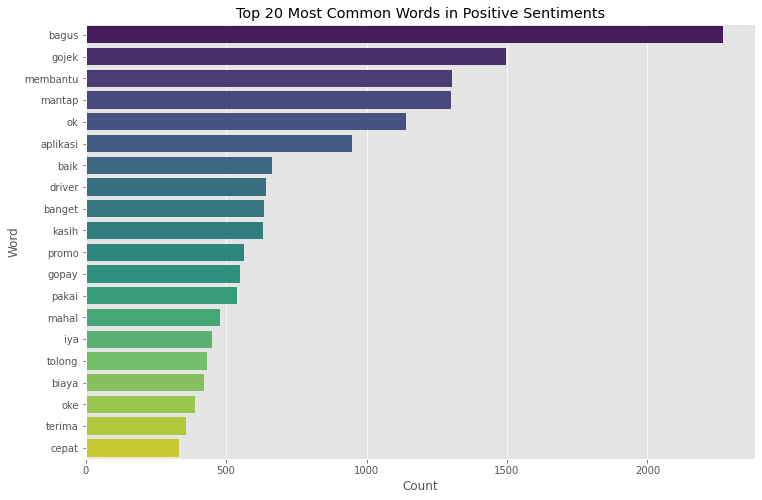

In [607]:
# Menghitung frekuensi setiap kata
word_freq = Counter(positive_text.split())
common_words = word_freq.most_common(20)  # Ambil 20 kata teratas atau Anda bisa mengatur sesuai kebutuhan Anda

# Memisahkan kata-kata dan frekuensinya ke dalam list terpisah
words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

# Membuat bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in Positive Sentiments')
plt.show()


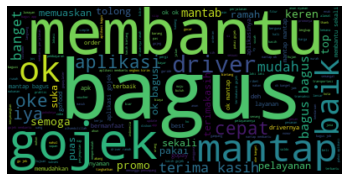

In [608]:
# Contoh: menggabungkan semua teks dari sentimen positif dalam satu string (asumsi dataframe Anda bernama df dan kolom teksnya bernama 'text')
positive_text = ' '.join(new_df[new_df['score_lexicon'] == 'positif']['content'].tolist())


wc = WordCloud().generate(positive_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

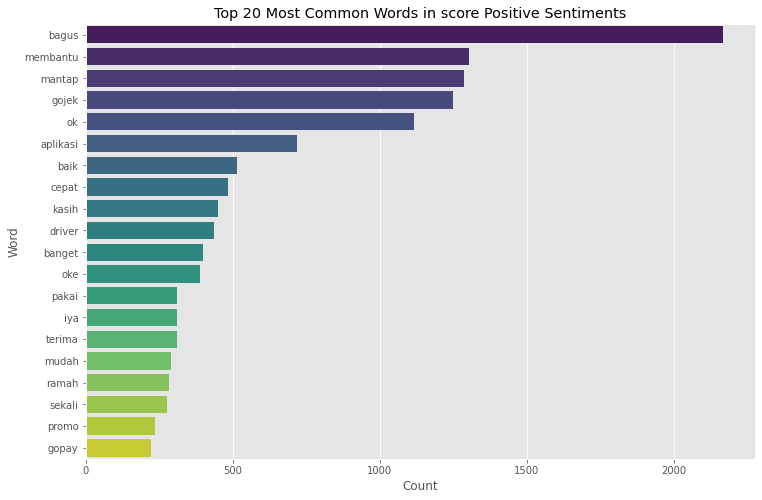

In [609]:
# Menghitung frekuensi setiap kata
word_freq = Counter(positive_text.split())
common_words = word_freq.most_common(20)  # Ambil 20 kata teratas atau Anda bisa mengatur sesuai kebutuhan Anda

# Memisahkan kata-kata dan frekuensinya ke dalam list terpisah
words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

# Membuat bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in score Positive Sentiments')
plt.show()

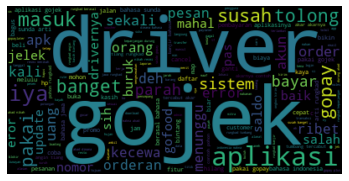

In [610]:
# Contoh: menggabungkan semua teks dari sentimen positif dalam satu string (asumsi dataframe Anda bernama df dan kolom teksnya bernama 'text')
negative_text = ' '.join(new_df[new_df['status_lexicon'] == 'negatif']['content'].tolist())


wc = WordCloud().generate(negative_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

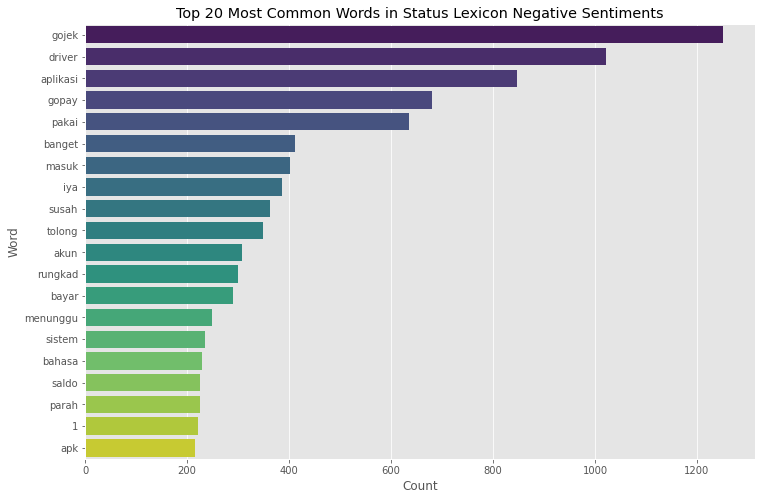

In [611]:
# Menghitung frekuensi setiap kata
word_freq = Counter(negative_text.split())
common_words = word_freq.most_common(20)  # Ambil 20 kata teratas atau Anda bisa mengatur sesuai kebutuhan Anda

# Memisahkan kata-kata dan frekuensinya ke dalam list terpisah
words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

# Membuat bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in Status Lexicon Negative Sentiments')
plt.show()

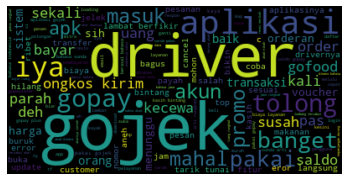

In [612]:
# Contoh: menggabungkan semua teks dari sentimen positif dalam satu string (asumsi dataframe Anda bernama df dan kolom teksnya bernama 'text')
negative_text = ' '.join(new_df[new_df['score_lexicon'] == 'negatif']['content'].tolist())


wc = WordCloud().generate(negative_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

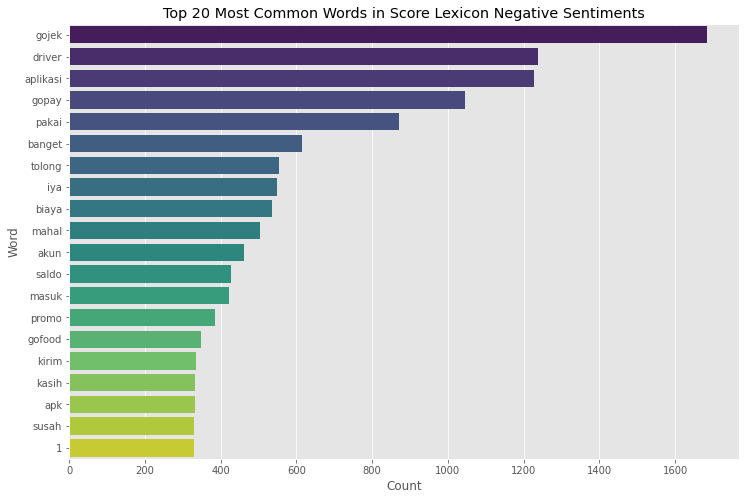

In [613]:
# Menghitung frekuensi setiap kata
word_freq = Counter(negative_text.split())
common_words = word_freq.most_common(20)  # Ambil 20 kata teratas atau Anda bisa mengatur sesuai kebutuhan Anda

# Memisahkan kata-kata dan frekuensinya ke dalam list terpisah
words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

# Membuat bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in Score Lexicon Negative Sentiments')
plt.show()

# Membuat Model ML 

In [614]:
# #import

from sklearn.neighbors import KNeighborsClassifier
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(new_df['content'])

# Mengambil label
y = new_df['score_lexicon']

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Membuat model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Memprediksi label untuk set pengujian
y_pred = knn.predict(X_test)

# Menampilkan laporan klasifikasi
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     negatif       0.63      0.63      0.63      2475
     neutral       0.11      0.01      0.01       327
     positif       0.80      0.85      0.82      5036

    accuracy                           0.75      7838
   macro avg       0.51      0.50      0.49      7838
weighted avg       0.72      0.75      0.73      7838



In [615]:
y_train.shape

(11757,)

In [616]:
testing_kalimat = tfidf.transform(['driver ugal ugalan'])
knn.predict(testing_kalimat)

array(['negatif'], dtype=object)

# Mencoba membuat Topic modeling LDA gensim

In [617]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Fungsi untuk pra-pemrosesan teks
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

# Aplikasikan fungsi pada konten ulasan Anda
processed_docs = new_df['content'].map(preprocess)

In [618]:
dictionary = gensim.corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


In [619]:
%%time
from gensim.models import CoherenceModel

# num_topics = 9  # Anda bisa menyesuaikan ini berdasarkan kebutuhan Anda
# coherenceModel = []
# for x in range(10,100,10):
#     lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=x,iterations=10, workers=4)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherenceModel.append(coherence_lda)
#     print(x)
#     print(coherence_lda)
    

CPU times: total: 0 ns
Wall time: 0 ns


In [620]:
for x in range(10,100,10):
    print(x)

10
20
30
40
50
60
70
80
90


In [621]:
# %%time
# num_topics = 9  # Anda bisa menyesuaikan ini berdasarkan kebutuhan Anda
# lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=30,iterations=10, workers=4)


In [622]:
# %%time
# from gensim.models import CoherenceModel

# # Hitung coherence score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()

# print('\nCoherence Score: ', coherence_lda)

In [623]:
# %%time
# from gensim.models import CoherenceModel

# # Hitung coherence score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()

# print('\nCoherence Score: ', coherence_lda)

In [624]:
# for idx, topic in lda_model.print_topics(-1):
#     print('Topik: {} \nKata-kata: {}\n'.format(idx, topic))


# Mencoba Uji Statistika

In [625]:
#uji EDA statistika dan statistika deskriptif

In [626]:
new_df.head()

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon,status_lexicon,score_lexicon
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[ok, terima, kasih]",8,-1,7,positif,positif
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[transfer, gopay, gopay, transfer, gopay]",0,0,0,neutral,positif
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[aman, cepat, sesuai, ekspektasi]",6,-3,3,positif,positif
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[aplikasi, membantu]",4,0,4,positif,positif
4,Boedi Arsih,5,2023-03-30 14:19:13,cepat sampainya,"[cepat, sampainya]",3,-3,0,neutral,positif


In [627]:
average_final_by_score = new_df.groupby('score')['final_lexicon'].mean()
print(average_final_by_score)

score
1   -1.889410
2    0.052154
3    0.434731
4    1.975655
5    2.689307
Name: final_lexicon, dtype: float64


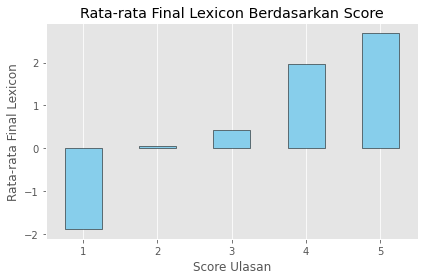

In [628]:
average_final_by_score.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rata-rata Final Lexicon Berdasarkan Score')
plt.xlabel('Score Ulasan')
plt.ylabel('Rata-rata Final Lexicon')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## Menggunakan Confusion_matrix

In [629]:
# consisten hasil dari score dengan based lexicon
consistency_check = new_df['status_lexicon'] == new_df['score_lexicon']
print(f"Konsistensi antara 'status_lexicon' dan 'score_lexicon': {consistency_check.mean() * 100:.2f}%")

Konsistensi antara 'status_lexicon' dan 'score_lexicon': 62.80%


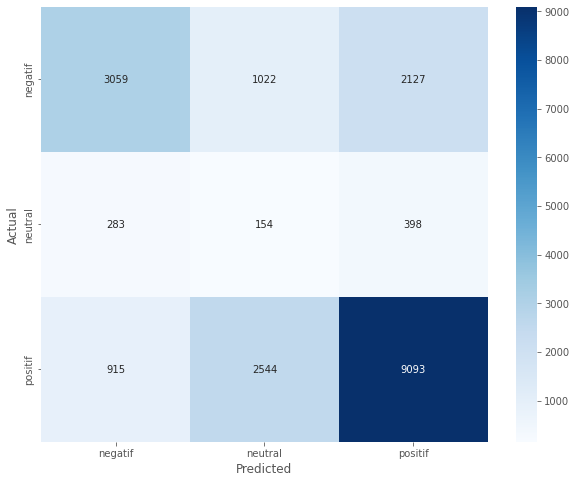

In [630]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Membuat confusion matrix
labels = ['negatif', 'neutral', 'positif']  # Urutan label penting untuk interpretasi
cm = confusion_matrix(new_df['score_lexicon'], new_df['status_lexicon'], labels=labels)

# Menampilkan confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [631]:
report = classification_report(new_df['score_lexicon'], new_df['status_lexicon'], target_names=labels)
print(report)

              precision    recall  f1-score   support

     negatif       0.72      0.49      0.58      6208
     neutral       0.04      0.18      0.07       835
     positif       0.78      0.72      0.75     12552

    accuracy                           0.63     19595
   macro avg       0.51      0.47      0.47     19595
weighted avg       0.73      0.63      0.67     19595



In [632]:
#check status lexicon yang positif tetapi pada actualnya negatif
wrong_pred_p_n = []
stop = 10
stop2 = 0
for x in new_df.index:
    for y in new_df.index:
        if new_df.loc[x,'status_lexicon'] == 'positif' and new_df.loc[y, 'score_lexicon'] == 'negatif':
            wrong_pred_p_n.append(y)       
    stop2 += 1
    print(stop2)
    if stop == stop2:
        break

print("finish")

1
2
3
4
5
6
7
8
9
10
finish


## Uji sample Estimasi Interval (Interval Kepercayaan)

In [633]:
min_val = new_df['final_lexicon'].min()
max_val = new_df['final_lexicon'].max()

new_df['normalized_final_lexicon'] = 1 + (new_df['final_lexicon'] - min_val) * 4 / (max_val - min_val)

In [634]:
from scipy import stats

confidence_level = 0.95
degrees_freedom = len(new_df['normalized_final_lexicon']) - 1
sample_mean = np.mean(new_df['normalized_final_lexicon'])
sample_standard_error = stats.sem(new_df['normalized_final_lexicon'])

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(f"Interval kepercayaan 95% untuk skor `final_lexicon`: {confidence_interval}")

Interval kepercayaan 95% untuk skor `final_lexicon`: (4.646418663077586, 4.647929686272342)


In [635]:
sample_standard_error

0.0003854483724005636

## Uji-t untuk membandingkan skor final_lexicon antara ulasan dengan score_lexicon positif dan negatif:

In [636]:
positif_group = new_df[new_df['score_lexicon'] == 'positif']['normalized_final_lexicon']
negatif_group = new_df[new_df['score_lexicon'] == 'negatif']['normalized_final_lexicon']

t_stat, p_value = stats.ttest_ind(positif_group, negatif_group)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 41.443272601132534
p-value: 0.0


##  Uji chi-kuadrat untuk membandingkan distribusi status_lexicon dan score_lexicon:

In [637]:
contingency_table = pd.crosstab(new_df['status_lexicon'], new_df['score_lexicon'])
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"chi-squared: {chi2}")
print(f"p-value: {p}")

chi-squared: 4502.6850501514755
p-value: 0.0


## ANOVA untuk membandingkan skor final_lexicon berdasarkan skor ulasan:

In [638]:
groups = [new_df['normalized_final_lexicon'][new_df['score'] == score] for score in new_df['score'].unique()]
f_stat, p_value = stats.f_oneway(*groups)

print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

F-statistic: 457.46594784866886
p-value: 0.0


# Membuat model menggunakan DL Neutral Network

# Word2Vec

In [639]:
#Prepare

#DATASET
TRAIN_SIZE = 0.8

W2V_SIZE = 100
W2V_WINDOW = 10
W2V_EPOCH = 32
W2V_MIN_COUNT = 5

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [640]:
#Split DF
df_train, df_test = train_test_split(new_df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 15676
TEST size: 3919


In [641]:
%%time
documents = [_content.split() for _content in df_train.content]


CPU times: total: 31.2 ms
Wall time: 19 ms


In [642]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [643]:
print(w2v_model)

Word2Vec<vocab=0, vector_size=100, alpha=0.025>


In [644]:
w2v_model.build_vocab(documents)

In [645]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2007


In [646]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: total: 5.95 s
Wall time: 2.18 s


(1954331, 2913536)

In [647]:
w2v_model.wv.most_similar("gopay")

[('gopaynya', 0.741756021976471),
 ('dana', 0.7020411491394043),
 ('banding', 0.6786978840827942),
 ('saldo', 0.6754557490348816),
 ('ovo', 0.6577898859977722),
 ('qris', 0.6538590788841248),
 ('saldonya', 0.6403663754463196),
 ('ilegal', 0.6376582980155945),
 ('blokir', 0.637327253818512),
 ('pengembalian', 0.6300119161605835)]